# Task 1 Constructing the matrix X

In [62]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix


import torch
import torch.optim as optim
from torch.utils.data import DataLoader

In [63]:
def construct_X(M, alphas, Np = None):
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
    i_indices = []
    j_indices = []
    weights = []

    N = len(alphas) * Np
    D = M * M
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype = numpy.float32),

    return X

In [64]:
def construct_X(M, alphas, Np=None):
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
    
    h = 1  # Pixel distance
    x = np.linspace(-(M-1)/2, (M-1)/2, M)
    y = np.linspace(-(M-1)/2, (M-1)/2, M)
    Cx, Cy = np.meshgrid(x, y)
    C = np.vstack([Cx.ravel(), Cy.ravel()])
    
    i_indices = []
    j_indices = []
    weights = []
    
    for alpha in alphas:
        theta = np.deg2rad(alpha)
        R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        p = R @ C
        p[0, :] += (Np-1) / 2
        
        for j in range(C.shape[1]):
            pj = p[:, j]
            sensor_idx = int(np.floor(pj[0]))
            if 0 <= sensor_idx < Np-1:
                i_indices.append(sensor_idx)
                j_indices.append(j)
                weights.append(1 - (pj[0] - sensor_idx))
                
                i_indices.append(sensor_idx + 1)
                j_indices.append(j)
                weights.append(pj[0] - sensor_idx)
    
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(len(alphas) * Np, M * M), dtype=np.float32)
    return X

In [65]:
directory = 'hs_tomography'

# M = 77 for small dataset 195 for bigger dataset
M = 77

# load the dataset
file_name_alpha = 'alphas_'+str(M)+'.npy'
file_name_y = 'y_'+str(M)+'.npy'

data_alpha = np.load(os.path.join(directory, file_name_alpha))
data_y = np.load(os.path.join(directory, file_name_y))
print("The shape of alpha: ", data_alpha.shape,'\n', "The shape of y:", data_y.shape)


# call function to construct X
X = construct_X(M, data_alpha, Np = None)

#print(X.shape)

The shape of alpha:  (90,) 
 The shape of y: (9810,)


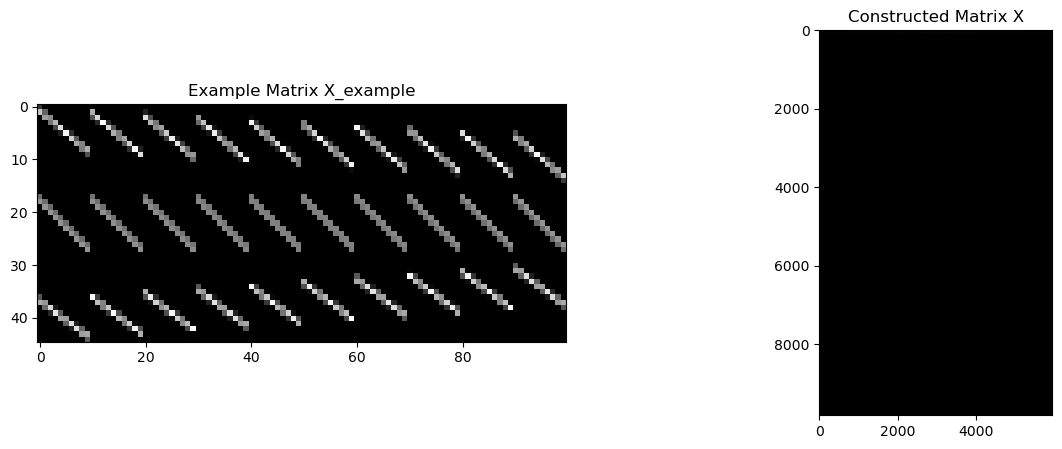

In [66]:
X_example = np.load('hs_tomography/X_example.npy')

#print(X_example)
# Convert sparse matrix X to dense format
X_dense = X.toarray()
#print(X_dense)
# Visualize both matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(X_example, cmap='gray')
axes[0].set_title('Example Matrix X_example')

axes[1].imshow(X_dense, cmap='gray')
axes[1].set_title('Constructed Matrix X')

plt.show()

# Task 2 Recovering the image

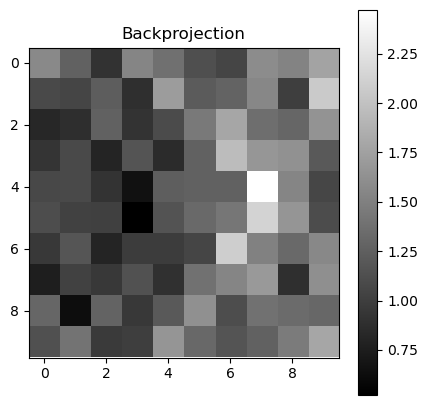

In [73]:

def backprojection(X, y):
    return X.T @ y

# Compute the backprojection
beta_backprojection = backprojection(X, y)

# Visualize the backprojection result
plt.figure(figsize=(5, 5))
plt.imshow(beta_backprojection.reshape(M, M), cmap='gray')
plt.title('Backprojection')
plt.colorbar()
plt.show()

# Tast 3 Minimizing the radiation dose

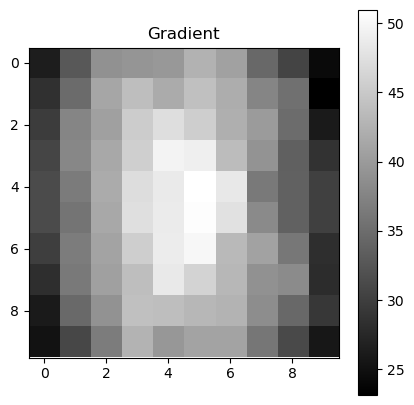

In [74]:

def gradient(X, y, beta):
    return X.T @ (X @ beta - y)

# Compute the gradient
grad = gradient(X, y, beta_example)


# Visualize the gradient
plt.figure(figsize=(5, 5))
plt.imshow(grad.reshape(M, M), cmap='gray')
plt.title('Gradient')
plt.colorbar()
plt.show()